# Random Forests

1. [Random Forests](#sec1)
2. [Examples](#sec2)
    1. [Spam or ham?](#sec2-1)
    2. [NIST](#sec2-2)

# <a id="sec1"></a> 1. Random Forests

Key idea: Grow a forest of trees by introducing randomness.

Randomness in:
-  Training subset selection (Bagging)
- Feature selection in each node

**Reminder: growing trees**

**FormTree($T$)**<br>
<ol>
<li> Find best split $(j, s)$ over $T$ // Which criterion?
<li> If $(j, s) = \emptyset$, 
    <ul>
    <li>  node = FormLeaf(T) // Which value for the leaf?
    </ul>
<li> Else
    <ul>
    <li> node = $(j, s)$
    <li> split $T$ according to $(j, s)$ into $(T1, T2)$
    <li> append FormTree($T1$) to node // Recursive call
    <li> append FormTree($T2$) to node
    </ul>
<li> Return node
</ol>

**New: random feature selection**

During step 1 (splitting) of FormTree(T), only search for the best split among a random subset of features.

Size of the subset has little importance. Usual choices:
- $\sqrt{p}$ in common cases
- 1 for fully randomized feature selection (still gives accurate results!)

**Reminder: Forest growth by Bagging of trees**

Example Set $T$, samples $x^1,\ldots, x^N$.<br>
For $b=1$ to $B$
1. Sample (with replacement) bootstrap replicate $T^b$ from $T$
2. $\varphi^b(x) \leftarrow$ FormTree($T^b$)

Return $\varphi_B(x) = \arg\max\limits_{y} \sum\limits_{b=1}^B I(\varphi^b(x) = y)$

<div class="alert alert-success">**Random Forests**
<ul>
<li> Fully grown trees
<li> + Random feature selection
<li> + Bagging
</ul>
</div>

**Margin guarantees?**

Margin of a random forest in $(x,y)$ = 
probability of classifying correctly $x$, minus probability of the most probable wrong class.<br>
$$m(x,y) = \mathbb{P}_\Theta\left(h\left(x,\Theta\right)=y\right) - \max\limits_{j\neq y}\mathbb{P}_\Theta\left(h\left(x,\Theta\right)=j\right)$$
As more trees are added, Random Forests converge to a bound in generalization error and do not overfit the training set.

**Alternatives to Random Forests?**
- Boosting (and the extension to the popular XGBoost algorithm),
- Extremely Randomized Trees.

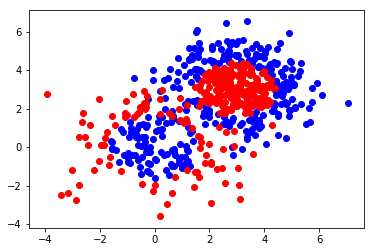

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

def gen_data(seed):
    X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=seed)
    X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=seed)
    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, - y2 + 1))
    y = 2*y-1
    X, y = shuffle(X, y)
    return X, y

X,y = gen_data(1)
Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(8,8))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
_=plt.scatter(Xred[:,0],Xred[:,1],c='r')

Generalization error: 0.0925


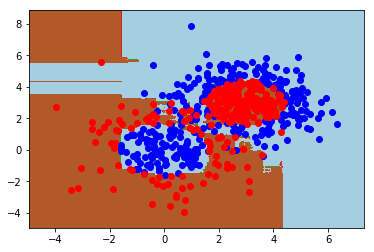

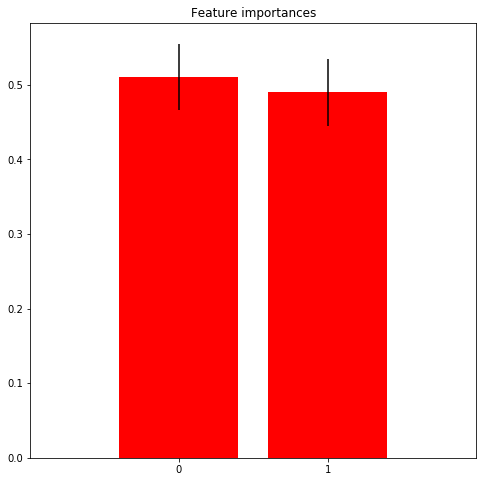

In [3]:
from sklearn.ensemble import RandomForestClassifier

### Generate data
X,y = gen_data(1)
Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

def plot_decision_boundary(f,X,y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = f.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure()
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = f.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

rf = RandomForestClassifier(n_estimators=101, criterion='entropy')
rf.fit(X,y)

# Plot
print("Generalization error: %g"%(1.-rf.score(Xtest,ytest)))
plt.figure(figsize=(8,8))
plot_decision_boundary(rf,X,y)

# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Random Forests provide an interesting **feature importance** estimation mechanism. Let's illustrate it.

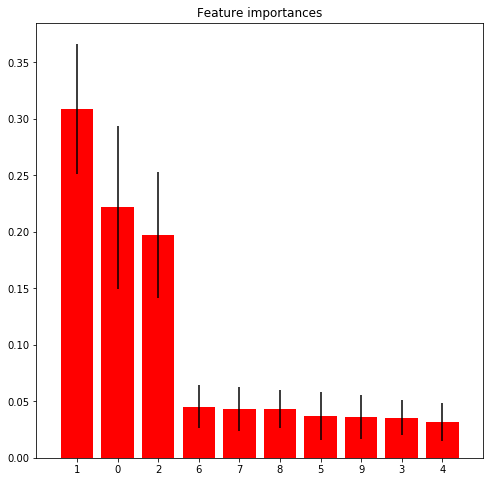

In [5]:
# A more demonstrative example
# Build a classification task using 10 features but only 3 informative ones.
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=10,
                                    n_informative=3,
                                    n_redundant=0,
                                    n_repeated=0,
                                    n_classes=2,
                                    random_state=0,
                                    shuffle=False)
rf = RandomForestClassifier(n_estimators=51, criterion='entropy')
rf.fit(X,y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# <a id="sec4"></a> 4. Examples

## <a id="sec4-1"></a> 4.1 Spam or ham?

In [7]:
from sys import path
path.append('../2 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()
print("data loaded")

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

data loaded


In [8]:
Xtrain.shape

(2000, 14279)

In [9]:
spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
spam_RF.score(Xtest.toarray(),ytest)

0.96976483762597987

In [11]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000)
    spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
    spam_RF.fit(Xtrain,ytrain);
    score += [spam_RF.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

******************** done!
Average generalization score: 0.975363941769
Standard deviation: 0.00516818846997


Let's see how the model behaves on raw word counts.

In [12]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain)
spam_RF.score(Xtest,ytest)

0.97536394176931696

In [13]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000, feat='wordcount')
    spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
    spam_RF.fit(Xtrain,ytrain);
    score += [spam_RF.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

******************** done!
Average generalization score: 0.981187010078
Standard deviation: 0.00416898330772


Let's keep this last classifier and identify which are the misclassified emails.

In [18]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat="wordcount")
spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain);

In [19]:
# Find misclassified examples
ypredict = spam_RF.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

Misclassified messages indices: [206, 302, 386, 402, 404, 413, 590, 594, 597, 661, 726, 776, 796, 808]


In [20]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:
[[742   1]
 [ 13 137]]


In [21]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_RF.predict(spam_data.word_count[index,:]))
spam_data.print_email(index)
spam_RF.predict_proba(spam_data.word_count[index,:])

Prediction: [False]
email file: ../data/lingspam_public/bare/part9/spmsgc33.txt
email is a spam: True
Subject: info

dear ion , i am very happy to have found you . i had no idea so many people also = share this interest in figurative language . i find this very exciting = because it 's the language i work in . the operational language of = computers is binary . the operational language of the human mind is = pictures . i use psychotherapy called metaphor therapy that takes all = figurative statements and treats them literally . if you take an = interest in figurative speech , i thought you might like to know more = about this . it 's an approach that looks for the figures in figurative = speech and uses them to heal or dissolve persistent uncomfortable = feelings . the figures of speech that salt out language reflect the inner figures = of the subconscious mind . so , for example , if someone says there 's a = cloud over his or her head , in the subconscious mind there is a cloud . = t

array([[0.765, 0.235]])

In [23]:
importances = spam_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in spam_RF.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

TypeError: object of type 'int' has no len()

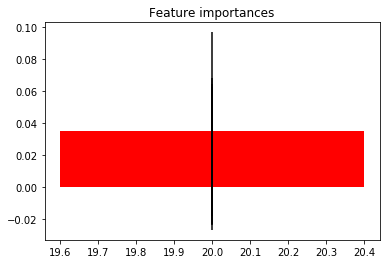

In [24]:
plt.figure()
plt.title("Feature importances")
plt.bar(20, importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(20, indices)
plt.xlim([-1, 20])
plt.show()

In [22]:
print(spam_data.word_count.shape)
print(spam_data.tfidf.shape)

(2893, 14279)
(2893, 14279)


## 4.2 <a id="sec4-1"></a> NIST

In [25]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

#plt.gray();
#plt.matshow(digits.images[0]);
#plt.show();
#plt.matshow(digits.images[15]);
#plt.show();
#plt.matshow(digits.images[42]);
#plt.show();

from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


In [26]:
print(Xtrain.shape)
print(ytrain.shape)
digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
digits_rf.fit(Xtrain,ytrain)
prediction = digits_rf.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_rf.score(Xtest,ytest))
print("Confusion matrix:")
print(confusion_matrix(ytest, prediction))

(1000, 64)
(1000,)
Generalization error: 0.06148055207026349
Generalization score: 0.9385194479297365
Confusion matrix:
[[78  0  0  0  1  0  0  0  0  0]
 [ 0 70  0  1  0  1  0  0  0  8]
 [ 1  1 69  4  0  0  0  0  0  2]
 [ 0  0  0 69  0  3  0  2  5  0]
 [ 1  0  0  0 78  1  0  2  0  1]
 [ 0  0  0  0  0 81  1  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 79  1  0]
 [ 0  2  0  0  0  2  0  1 70  1]
 [ 1  0  0  2  0  3  0  0  1 74]]


In [25]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
    digits_rf.fit(Xtrain,ytrain)
    score += [digits_rf.score(Xtest,ytest)]
    print('*',end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

******************** done!
Average generalization score: 0.9713927227101632
Standard deviation: 0.006405143798293705


Let's identify the misclassified images.

In [27]:
# Retrain
Xtrain = X[:1000,:]
ytrain = y[:1000]
Xtest = X[1000:,:]
ytest = y[1000:]
digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
digits_rf.fit(Xtrain,ytrain);

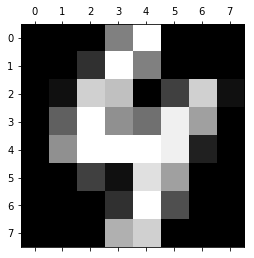

prediction on image number 1053 : [4]
correct label                : 4


In [28]:
# Examples
N = 1053
plt.gray();
plt.matshow(digits.images[N]) 
plt.show() 
x = digits.data[N,:]
print("prediction on image number", N, ":", digits_rf.predict([digits.data[N,:]]))
print("correct label                :", digits.target[N])

In [29]:
# Find misclassified examples
ypredict = digits_rf.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Itest = digits.images[1000:,:]
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
Imisclass = Itest[misclass,:]

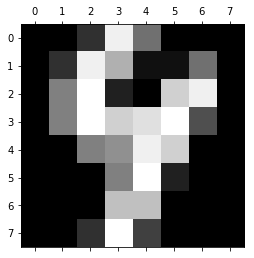

prediction on image number 3 : [9]
correct label                : 4


In [34]:
# Display misclassified examples
N = 3
plt.matshow(Imisclass[N]) 
plt.show() 
print("prediction on image number", N, ":", digits_rf.predict([Xmisclass[N,:]]))
print("correct label                :", ymisclass[N])

Let's take a look at the important pixels.

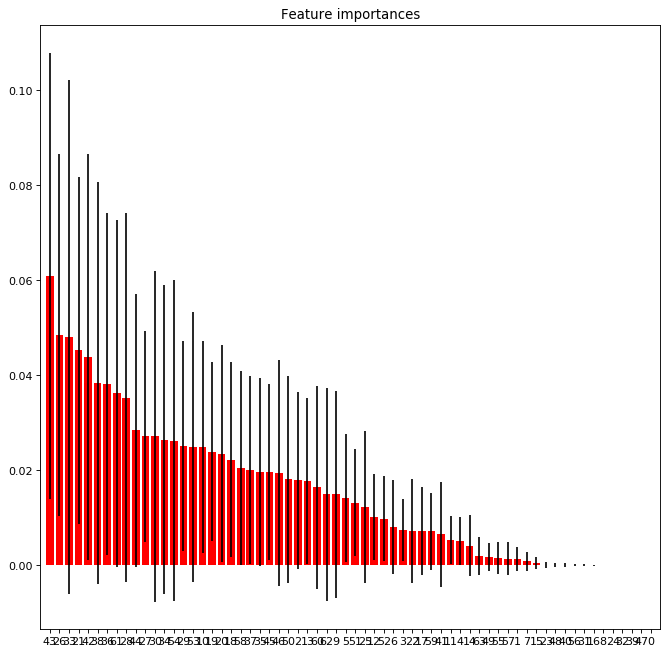

In [35]:
importances = digits_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in digits_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
fig=plt.figure(figsize=(10,10), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

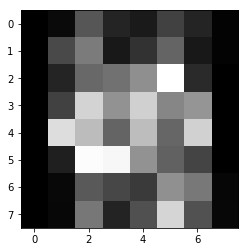

In [31]:
importances_image = importances.reshape((8,8))
plt.imshow(importances_image);